In [1]:
from RNN_QSR import *
from Patched_TF import PE2D
def patch2D(x,n,Lx):
    # type: (Tensor,int,int) -> Tensor
    """patch your sequence into chunks of 4"""
    #make the input 2D then break it into 2x2 chunks 
    #afterwards reshape the 2x2 chunks to vectors of size 4 and flatten the 2d bit
    return x.view([x.shape[0],Lx,Lx]).unfold(-2,n,n).unfold(-2,n,n).reshape([x.shape[0],int(Lx*Lx//n**2),int(n**2)])

def unpatch2D(x,n,Lx):
    # type: (Tensor,int,int) -> Tensor
    """inverse function for patch"""
    # original sequence order can be retrieved by chunking twice more
    #in the x-direction you should have chunks of size 2, but in y it should
    #be chunks of size Ly//2
    return x.unfold(-2,Lx//n,Lx//n).unfold(-2,n,n).reshape([x.shape[0],Lx*Lx])


Lx=6
a = torch.arange(Lx**2).unsqueeze(0)
print(a)
print(a.view([Lx,Lx]))
b = patch2D(a,3,Lx)
print(b)
c = unpatch2D(b,3,Lx)
print(c)

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  2,  6,  7,  8, 12, 13, 14],
         [ 3,  4,  5,  9, 10, 11, 15, 16, 17],
         [18, 19, 20, 24, 25, 26, 30, 31, 32],
         [21, 22, 23, 27, 28, 29, 33, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]])


# The below functions are only for patches of size 4

In [2]:
@torch.jit.script
def patch2idx(patch):
    #moving the last dimension to the front
    patch=patch.unsqueeze(0).transpose(-1,0).squeeze(-1)
    out=torch.zeros(patch.shape[1:],device=patch.device)
    for i in range(4):
        out+=patch[i]<<i
    return out.to(torch.int64)

@torch.jit.script
def patch2onehot(patch):
    #moving the last dimension to the front
    patch=patch.unsqueeze(0).transpose(-1,0).squeeze(-1)
    out=torch.zeros(patch.shape[1:],device=patch.device)
    for i in range(4):
        out+=patch[i]<<i
    return nn.functional.one_hot(out.to(torch.int64), num_classes=16)

In [3]:
class PTFRNN(Sampler):#(torch.jit.ScriptModule):
    TYPES={"GRU":nn.GRU,"ELMAN":nn.RNN,"LSTM":nn.LSTM}
    """
    
    Sampler class which uses a transformer for long term information and an RNN for short term information.
    
    The sequence is broken into 2D patches (4x4 by default), each patch is expanded to a tensor of size Nh (be repeating it),\
    then a positional encoding is added. You then apply masked self-attention to the patches num_layers times, with the final
    outputs fed in as the initial hidden state of an rnn.
    
    Going with 4x4 patches, you can use these patches as a sequence to get a factorized probability of the entire
    4x4 patch by feeding the 2x2 patches in one at a time and outputting a size 16 tensor 
    (probability of all possible next 2x2 patches) for each patch. The output is obtained by applying two FC layers to
    the hidden state of the rnn.
    
    
    Here is an example of how everything comes together
    
    Say you have a 16x16 input and Nh=128, this input is broken into 16 4x4 patches which are repeated 8 times and
    given a positional encoding. Masked self attention is done between the 16 patches (size Nh) for N layers, then
    16 RNNs are given the outputs in parallel as the hidden state. Now the original input is broken into 16 sets of 4 2x2
    patches. These length 4 sequences are given to the rnns (16 in parallel all sharing the same weights) and the outputs
    are then grouped together such that you end up with a length 64 sequence of vectors of size 16. this gives your probability.
    You can easily calculate it by taking the output (of 16) corresponding to each 2x2 patch and multiplying all 64 of them
    together (or adding them in logscale).
    
    """
    def __init__(self,Lx,px=4,device=device,Nh=128,dropout=0.0,num_layers=2,nhead=8,rnn_patch=4,rnntype="GRU", **kwargs):
        super(PTFRNN, self).__init__()
        #print(nhead)
        self.pe = PE2D(Nh, Lx,Lx,device)
        self.device=device
        #Encoder only transformer
        #misinterperetation on encoder made it so this code does not work
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=Nh, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        
        assert rnn_patch==4
        #have to do more work to implement other values but I may want to do so later
        
        assert rnntype!="LSTM"
        #rnn takes input shape [B,L,1]
        self.rnn = RNN.TYPES[rnntype](input_size=rnn_patch,hidden_size=Nh,batch_first=True)
        
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,2**rnn_patch),
                nn.Softmax(dim=-1)
            )
        
        #sequence size in x
        self.Lx=Lx
        #transformer patch size in x
        self.px=px
        #transformer patch size
        self.p=px**2
        #rnn patch size
        self.prnn=rnn_patch
        
        self.set_mask(Lx**2//self.p)
        
        self.options=torch.zeros([16,4],device=self.device)
        tmp=torch.arange(16,device=self.device)
        for i in range(4):
            self.options[:,i]=(tmp>>i)%2
        
        
        self.to(device)
        
    def set_mask(self, L):
        # type: (int)
        # take the log of a lower triangular matrix
        self.L=L
        self.mask = torch.log(torch.tril(torch.ones([L,L],device=self.device)))
        self.pe.L=L
        
    
    def rnnforward(self,hidden,input):
        """
        Inputs:
            hidden - shape [L/p,B,Nh] tensor
            input - shape [L/p,B,p] tensor
        Outputs
            out - shape [L/p,B,p/4,Nh] tensor
        """
        
        Lp,B,Nh=hidden.shape
        h0 = hidden.view([1,Lp*B,Nh])
        input = patch2D(input.reshape([Lp*B,self.p]),2,self.px)
        #probably need this?
        input[:,1:]=input[:,:-1]
        input[:,0]=0
        
        out,h=self.rnn(input,h0)
        return out.view([Lp,B,self.p//4,Nh])
        
        
    def forward(self, input):
        # input is shape [B,L,1]
        # add positional encoding to get shape [B,L,Nh]
        if input.shape[1]//self.p!=self.L:
            self.set_mask(input.shape[1]//self.p)
        
        input=patch2D(input.squeeze(-1),self.px,self.Lx).transpose(1,0)
        #pe should be sequence first [L/p,B,Nh]
        hidden = self.transformer(self.pe(input),self.mask)        
        rnnout = self.rnnforward(hidden,input)
        
        #[L/p,B,p/4,Nh] -> [B,L/4,16]
        output = self.lin(rnnout).transpose(1,0).view([rnnout.shape[1],rnnout.shape[0]*rnnout.shape[2],16])
        return output
    
    def next_with_cache(self,tgt,cache=None,idx=-1):
        # type: (Tensor,Optional[Tensor],int) -> Tuple[Tensor,Tensor]
        """Efficiently calculates the next output of a transformer given the input sequence and 
        cached intermediate layer encodings of the input sequence
        
        Inputs:
            tgt - Tensor of shape [L,B,1]
            cache - Tensor of shape ?
            idx - index from which to start
            
        Outputs:
            output - Tensor of shape [?,B,1]
            new_cache - Tensor of shape ?
        """
        #HMMM
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i,layer in enumerate(self.transformer.layers):
            
            tgt=output
            #have to merge the functions into one
            src = tgt[idx:, :, :]
            mask = None if idx==-1 else self.mask[idx:]

            # self attention part
            src2 = layer.self_attn(
                src,#only do attention with the last elem of the sequence
                tgt,
                tgt,
                attn_mask=mask,  
                key_padding_mask=None,
            )[0]
            #straight from torch transformer encoder code
            src = src + layer.dropout1(src2)
            src = layer.norm1(src)
            src2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(src))))
            src = src + layer.dropout2(src2)
            src = layer.norm2(src)
            #return src
            
            output = src#self.next_attn(output,layer,idx)
            new_token_cache.append(output)
            if cache is not None:
                #layers after layer 1 need to use a cache of the previous layer's output on each input
                output = torch.cat([cache[i], output], dim=0)

        #update cache with new output
        if cache is not None:
            new_cache = torch.cat([cache, torch.stack(new_token_cache, dim=0)], dim=1)
        else:
            new_cache = torch.stack(new_token_cache, dim=0)

        return output, new_cache
    
    def make_cache(self,tgt):
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i, layer in enumerate(self.transformer.layers):
            output = layer(output,src_mask=self.mask)#self.next_attn(output,layer,0)
            new_token_cache.append(output)
        #create cache with tensor
        new_cache = torch.stack(new_token_cache, dim=0)
        return output, new_cache
    
    @torch.jit.export
    def sample_with_labelsALT(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor,Tensor]
        sample,probs = self.sample_with_labels(B,L,grad,nloops)
        logsqrtp=probs.mean(dim=1)/2
        sumsqrtp = torch.exp(probs/2-logsqrtp.unsqueeze(1)).sum(dim=1)
        return sample,sumsqrtp,logsqrtp
    @torch.jit.export
    def sample_with_labels(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor]
        sample=self.sample(B,L,None)
        return self._off_diag_labels(sample,B,L,grad,nloops)
    
    @torch.jit.export
    def sample(self,B,L,cache=None):
        # type: (int,int,Optional[Tensor]) -> Tensor
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        return self.sampleDebug(B,L,cache)[0]
    @torch.jit.export
    def sampleDebug(self,B,L,cache=None):
        # type: (int,int,Optional[Tensor]) -> Tuple[Tensor,Tensor]


        #length is divided by four due to patching
        L=L//self.p
        
        DEBUG=torch.zeros([B],device=self.device)
        #return (torch.rand([B,L,1],device=device)<0.5).to(torch.float32)
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        input = torch.zeros([L+1,B,self.p],device=self.device)
         
        with torch.no_grad():
          for idx in range(1,L+1):
            
            #pe should be sequence first [L,B,Nh]
            encoded_input = self.pe(input[:idx,:,:])
                        
            #Get transformer output
            output,cache = self.next_with_cache(encoded_input,cache)
            
            h = output[-1,:,:].unsqueeze(0)
            
            rnnseq = torch.zeros([B,self.p//4+1,4],device=self.device)
            for rdx in range(1,self.p//4+1):
                
                out,h=self.rnn(rnnseq[:,rdx-1:rdx,:],h)
                #check out the probability of all 16 vectors
                probs=self.lin(out).view([B,16])
                #sample from the probability distribution
                indices = torch.multinomial(probs,1,False).squeeze(1)
                #extract samples
                sample = self.options[indices]
                #add sample to sequence
                rnnseq[:,rdx] = sample
                
                #debugging info
                real=patch2onehot(sample)
                total = torch.sum(real*probs,dim=-1)
                DEBUG+=torch.log(total)
                
            #set input to the (unpatched) rnn sequence
            input[idx] = unpatch2D(rnnseq[:,1:],2,self.px)
            
        #remove the leading zero in the input    
        input=input[1:]
        #sample is repeated 16 times at 3rd index so we just take the first one
        return unpatch2D(input.transpose(1,0),self.px,self.Lx).unsqueeze(-1),DEBUG
    
    
    @torch.jit.export
    def logprobability(self,input):
        # type: (Tensor) -> Tensor
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
                
        if input.shape[1]//self.p!=self.L:
            self.set_mask(input.shape[1]//self.p)
        
        #shape is modified to [L//p,B,p]
        input = patch2D(input.squeeze(-1),self.px,self.Lx).transpose(1,0)
        
        data=torch.zeros(input.shape,device=self.device)
        data[1:]=input[:-1]
        
        #[L//p,B,p] -> [L//p,B,Nh]
        encoded=self.pe(data)
        # [L//p,B,Nh] -> [L//p,B,Nh]
        hidden = self.transformer(encoded,self.mask)     
        # [L//p,B,Nh],[L//p,B,p] -> [L/p,B,p/4,Nh]
        rnnout = self.rnnforward(hidden,input)
        
        #[L/p,B,p/4,Nh] -> [B,L/4,16]
        output = self.lin(rnnout).transpose(1,0).reshape([rnnout.shape[1],rnnout.shape[0]*rnnout.shape[2],16])
        
        #real is going to be a onehot with the index of the appropriate patch set to 1
        #shape will be [B,L//4,16]
        
        Lp,B,Nh=hidden.shape
        
        
        
        #reshaping the input to match the shape of the output (idk if this is correct tbh)
        susman = patch2D(input.reshape([Lp*B,self.p]),2,self.px).view([Lp,B,self.p//4,4]).transpose(1,0)

        
        #print(susman[:,0])
        
        real=patch2onehot(susman).reshape([rnnout.shape[1],rnnout.shape[0]*rnnout.shape[2],16])
        
        #print(real.shape,output.shape)
        
        #[B,L//4,16] -> [B,L//4]
        total = torch.sum(real*output,dim=-1)
        #[B,L//4] -> [B]
        logp=torch.sum(torch.log(total+1e-10),dim=1)
        return logp

    
    
    
    @torch.jit.export
    def _off_diag_labels(self,sample,B,L,grad,D=1):
        # type: (Tensor,int,int,bool,int) -> Tuple[Tensor, Tensor]
        """label all of the flipped states  - set D as high as possible without it slowing down runtime
        Parameters:
            sample - [B,L,1] matrix of zeros and ones for ground/excited states
            B,L (int) - batch size and sequence length
            D (int) - Number of partitions sequence-wise. We must have L%D==0 (D divides L)
            
        Outputs:
            
            sample - same as input
            probs - [B,L] matrix of probabilities of states with the jth excitation flipped
        """
        
        
        
        sample0=sample
        #sample is batch first at the moment
        sample = patch2D(sample.squeeze(-1),self.px,self.Lx)
        
        sflip = torch.zeros([B,L,L//self.p,self.p],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L//self.p):
            #have to change the order of in which states are flipped for the cache to be useful
            for j2 in range(self.p):
                sflip[:,j*self.p+j2] = sample*1.0
                sflip[:,j*self.p+j2,j,j2] = 1-sflip[:,j*self.p+j2,j,j2]
            
        #switch sample into sequence-first
        sample = sample.transpose(1,0)
            
        #compute all of their logscale probabilities
        with torch.no_grad():
            

            data=torch.zeros(sample.shape,device=self.device)
            data[1:]=sample[:-1]
            
            #[L//4,B,4] -> [L//4,B,Nh]
            encoded=self.pe(data)
            
            #add positional encoding and make the cache
            out,cache=self.make_cache(encoded)

            probs=torch.zeros([B,L],device=self.device)
            #expand cache to group L//D flipped states
            cache=cache.unsqueeze(2)

            #this line took like 1 hour to write I'm so sad
            #the cache has to be shaped such that the batch parts line up
                        
            cache=cache.repeat(1,1,L//D,1,1).transpose(2,3).reshape(cache.shape[0],L//self.p,B*L//D,cache.shape[-1])

            
            
            rnnout = self.rnnforward(out,sample)
            #[L/p,B,p/4,Nh] -> [B,L/4,16]
            pred0 = self.lin(rnnout).transpose(1,0).reshape([rnnout.shape[1],rnnout.shape[0]*rnnout.shape[2],16])
            #real is going to be a onehot with the index of the appropriate patch set to 1
            #shape will be [B,L//4,16]
            Lp,B,Nh=out.shape
            #reshaping the input to match the shape of the output (idk if this is correct tbh)
            susman = patch2D(sample.reshape([Lp*B,self.p]),2,self.px).view([Lp,B,self.p//4,4]).transpose(1,0)
            real=patch2onehot(susman).reshape([rnnout.shape[1],rnnout.shape[0]*rnnout.shape[2],16])

            
            #[B,L//4,16] -> [B,L//4]
            total0 = torch.sum(real*pred0,dim=-1)

            for k in range(D):

                N = k*L//D
                #next couple of steps are crucial          
                #get the samples from N to N+L//D
                #Note: samples are the same as the original up to the Nth spin
                real = sflip[:,N:(k+1)*L//D]
                #flatten it out and set to sequence first
                tmp = real.reshape([B*L//D,L//self.p,self.p]).transpose(1,0)
                #set up next state predction
                fsample=torch.zeros(tmp.shape,device=self.device)
                fsample[1:]=tmp[:-1]
                # put sequence before batch so you can use it with your transformer
                tgt=self.pe(fsample)
                #grab your transformer output
                out,_=self.next_with_cache(tgt,cache[:,:N//self.p],N//self.p)
                #only the newly computed parts are necessary
                out = out [N//self.p:]
                
                rnnout = self.rnnforward(out,tmp[N//self.p:])
                
                Lp,Bp,Nh=out.shape
                
                
                # grab output for the new part
                output = self.lin(rnnout).transpose(1,0).reshape([rnnout.shape[1],rnnout.shape[0]*rnnout.shape[2],16])
                
                # reshape output separating batch from spin flip grouping
                pred = output.view([B,L//D,(L-N)//4,16])
                
                susman = patch2D(tmp[N//self.p:].reshape([Lp*Bp,self.p]),2,self.px).view([Lp,Bp,self.p//4,4]).transpose(1,0)
        
                real=patch2onehot(susman).reshape([rnnout.shape[1],rnnout.shape[0]*rnnout.shape[2],16])
                
                real = real.view([B,L//D,(L-N)//4,16])
                
                total = torch.sum(real*pred,dim=-1)
                #sum across the sequence for probabilities
                
                #print(total.shape,total0.shape)
                logp=torch.sum(torch.log(total+1e-10),dim=-1)
                logp+=torch.sum(torch.log(total0[:,:N//4]+1e-10),dim=-1).unsqueeze(-1)
                probs[:,N:(k+1)*L//D]=logp
                
        return sample0,probs
    @torch.jit.export
    def ffq(self,samplequeue,sump_queue,sqrtp_queue,Q,K,L,NLOOPS):
        # type: (Tensor,Tensor,Tensor,int,int,int,int)
        for i in range(Q):
            sample,sump,sqrtp = self.sample_with_labelsALT(K,L,grad=False,nloops=NLOOPS)
            samplequeue[i*K:(i+1)*K]=sample
            sump_queue[i*K:(i+1)*K]=sump
            sqrtp_queue[i*K:(i+1)*K]=sqrtp

In [4]:
pb = PTFRNN(8)
sample,p0 = pb.sampleDebug(6,8*8)

print(sample.shape)

ps = pb.logprobability(sample)

print(ps.shape)

torch.Size([6, 64, 1])
torch.Size([6])


In [5]:
print("",ps,'\n',p0)

 tensor([-43.9952, -44.3971, -44.2783, -44.2749, -43.9387, -44.4712],
       device='cuda:0', grad_fn=<SumBackward1>) 
 tensor([-43.9952, -44.3972, -44.2783, -44.2749, -43.9389, -44.4713],
       device='cuda:0')


In [6]:
def get_indices(px,Lx):
    sflip = torch.arange(Lx*Lx,device=device).to(torch.int64).reshape([1,Lx,Lx])
    sflip = patch2D(sflip,px,Lx).reshape(Lx*Lx)
    
    return sflip

if False:
    B=32

    s = pb.sample(B,8*8)
    probs = super(PTFRNN,pb)._off_diag_labels(s,B,8*8,False,D=4)[1][:,get_indices(4,8)]
    
    p2 = pb._off_diag_labels(s,B,8*8,False,D=4)[1]

    print(abs(probs-p2).mean().item(),torch.var_mean(probs)[0].item()**0.5)
    print(probs.mean(),p2.mean())
    print(abs(probs-p2).max())
    plt.imshow(abs(probs-p2).cpu())

In [7]:
op=Opt()
Lx=48
op.L=Lx*Lx
op.Nh=128
op.lr=5e-4
op.M=0.9
op.Q=8
op.K=32
op.USEQUEUE=0
op.kl=0.0
#op.apply(sys.argv[1:])
op.B=op.K*op.Q

#op.steps=4000
op.dir="PTFRNN"
#op.steps=100
op.NLOOPS=36
op.ffq=True
print(op)
op.patch_size=8

L                             			2304
Q                             			8
K                             			32
B                             			256
TOL                           			0.15
M                             			0.9
USEQUEUE                      			0
NLOOPS                        			36
hamiltonian                   			Rydberg
steps                         			12000
dir                           			PTFRNN
Nh                            			128
lr                            			0.0005
kl                            			0.0
ffq                           			True



In [8]:
#os.system("python PTFRNN.py "+op.cmd())

In [9]:
trainsformer = torch.jit.script(PTFRNN(Lx,Nh=op.Nh,px=op.patch_size))

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
trainsformer.parameters(), 
lr=op.lr, 
betas=(beta1,beta2)
)

C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\jit\_recursive.py:229: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


In [10]:
print(sum([p.numel() for p in trainsformer.parameters()]))

1849104


In [11]:
if op.USEQUEUE:
    queue_train(op,(trainsformer,sampleformer,optimizer))
else:
    print("Training. . .")
    reg_train(op,(trainsformer,optimizer))

Training. . .
Output folder path established
-0.3645 2304
13,2.941|
5485,-0.318|10996,-0.321|16488,-0.324|21986,-0.325|27511,-0.328|33017,-0.332|38513,-0.335|44010,-0.339|
49503,-0.341|54995,-0.342|60483,-0.345|65971,-0.347|71460,-0.348|76977,-0.348|82495,-0.349|87981,-0.351|
93473,-0.353|98957,-0.355|104445,-0.356|109936,-0.356|115428,-0.356|120919,-0.356|126409,-0.357|131889.2290611267 12000


In [12]:
op.steps=2000
reg_train(op,(trainsformer,optimizer))

Output folder path established
-0.3645 2304
11,-0.358|
5496,-0.360|10982,-0.361|16466,-0.360|21947.088606595993 2000


In [1]:
from PTFRNN import *

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)


In [2]:
op=Opt(K=256,Q=1,Nh=128,dir="<NONE>",hamiltonian="TFIM",J=1,h=-1)
op.B=op.K*op.Q
op.patch=20
op.L= 100
op.sgrad=False
op.NLOOPS=op.L//op.patch

pb = PTFRNN(op.L,op.patch,_2D=op._2D,Nh=op.Nh,num_layers=2,rnnargs={"p":4})

pb1 = torch.jit.script(pb)

print(sum([p.numel() for p in pb.parameters()]))

C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\jit\_recursive.py:229: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


1849104


torch.Size([32, 100, 1])
0.000909268856048584 8.305120648834622
--------------------
7.437526801368222e-05 8.080736457574726
tensor(-34.2419, device='cuda:0') tensor(-34.2419, device='cuda:0')
tensor(0.0009, device='cuda:0')


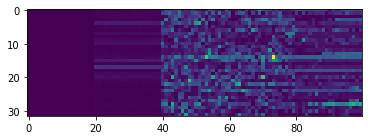

In [4]:
B=32

sample,p0 = pb.sample(B,100)
print(sample.shape)
ps = pb.logprobability(sample)

pvar,pmean = torch.var_mean(p0)

var,mean = torch.var_mean(abs(p0-ps))

print(mean.item(),pvar.item()**0.5)

print("--------------------")

probs = super(PTFRNN,pb).off_diag_labels(sample,nloops=op.NLOOPS)
p2 = pb.off_diag_labels(sample,nloops=op.NLOOPS)

print(abs(probs-p2).mean().item(),torch.var_mean(probs)[0].item()**0.5)
print(probs.mean(),p2.mean())
print(abs(probs-p2).max())
plt.imshow(abs(probs-p2).cpu())

In [3]:
op.steps=100

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
pb.parameters(), 
lr=op.lr,
betas=(beta1,beta2)
)

debug = reg_train(op,(pb,optimizer))

-1.2732919061200112 100
0,-1.002|
7.844459772109985 100
